In [2]:
# ! pip install imbalanced-learn
# ! pip install lime
# ! pip install textblob
# ! pip install contractions
# ! pip install spacy
# ! python -m spacy download en_core_web_sm
# ! pip install python-Levenshtein
# ! pip install wordcloud
# ! pip install treeinterpreter

In [97]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

import pickle 
import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
import time

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud
import lime
import lime.lime_tabular
from lime.lime_text import LimeTextExplainer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, plot_confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, IncrementalPCA, LatentDirichletAllocation

from helpers import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load cleaned data
combine title and body of text 

In [4]:
aita_2 = pd.read_csv('data/aita_save2.csv')

In [34]:
X = aita.drop('is_asshole', axis=1)
y = aita['is_asshole']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.01, random_state=21)
print(X_train.shape, X_test.shape)

(75232, 7) (760, 7)


In [35]:
Counter(y)

Counter({1: 20786, 0: 55206})

In [100]:
text_not_a = " ".join(post for post in aita['body_clean'][aita['is_asshole']==0])
text_a = " ".join(post for post in aita['body_clean'][aita['is_asshole']==1])

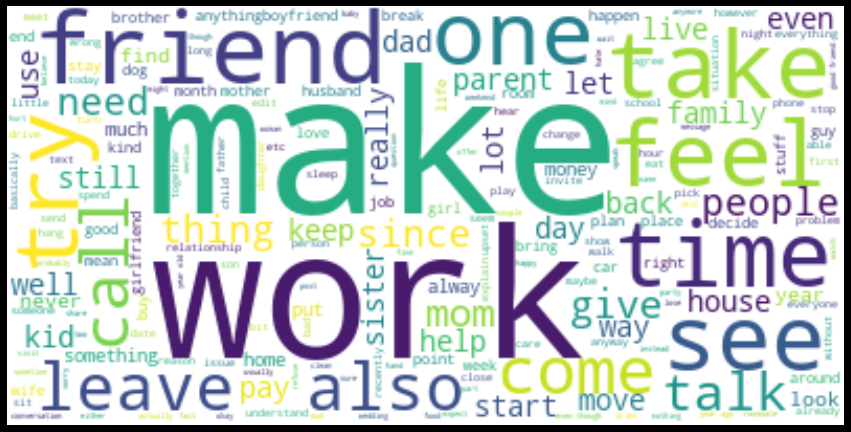

In [103]:
stop = set(stopwords.words('english')).union(['aita','wibta','asshole','say','go','would','ask','get','could','tell','want','know','think','like'])

# Generate a word cloud image
wordcloud_nta = WordCloud(stopwords=stop, background_color="white").generate(text_not_a)
# Display the generated image:
plt.figure(figsize=[15,15])
plt.imshow(wordcloud_nta, interpolation='bilinear')
plt.axis("off")
plt.show()

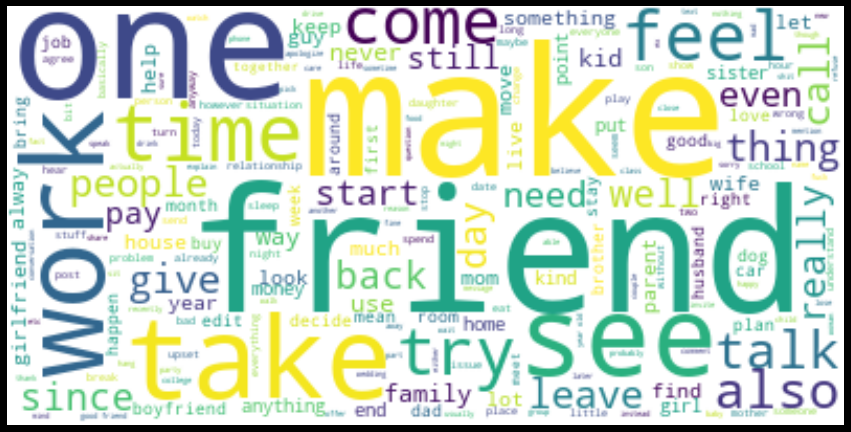

In [104]:
text_a = " ".join(post for post in aita['body_clean'][aita['is_asshole']==1])
wordcloud_a = WordCloud(stopwords=stop, background_color="white").generate(text_a)
# Display the generated image:
plt.figure(figsize=[15,15])
plt.imshow(wordcloud_a, interpolation='bilinear')
plt.axis("off")
plt.show()

## 2 - Instantiate CountVectorizer 

In [36]:
add_stop_words = ['like', 'get', 'go', 'say', 'tell', 'thats', 'want', 'time',
                  'youre', 'got', 'gonna', 'time', 'also', 'yeah', 'said']
stop = set(stopwords.words('english')).union(add_stop_words)
vec = CountVectorizer(stop_words=stop, min_df=0.005, max_df=0.8, ngram_range=(1, 2))
cv = vec.fit(X_train['title_body_combo'])
len(cv.get_feature_names())
# 3204

3204

In [37]:
# pickle.dump(cv, open('models/cv_fit_train_min5.sav', 'wb'))
# cv = pickle.load(open('models/cv_fit_train_min10.sav', 'rb'))
len(cv.get_feature_names())
# 3204

3204

### 2.a Transform train and test data into document-term-matrix with CountVectorizer

In [38]:
cv_train = cv.transform(X_train['title_body_combo'])
cv_test = cv.transform(X_test['title_body_combo'])
cv_cols = cv.get_feature_names()
dtm_train = pd.DataFrame(cv_train.toarray(), columns=cv_cols, index=X_train.index)
dtm_test = pd.DataFrame(cv_test.toarray(), columns=cv_cols, index=X_test.index)

In [39]:
dtm_train.shape, dtm_test.shape

((75232, 3204), (760, 3204))

## 3 - PCA

In [21]:
# pca = IncrementalPCA(n_components=1000, batch_size=1050)
# pca.fit(dtm_train)
# print(pca.explained_variance_ratio_.sum())

0.8858948258154675


In [22]:
# pickle.dump(pca, open('models/pca_min10.sav', 'wb'))
# # pca = pickle.load(open('models/pca_min10.sav', 'rb'))
# print(pca.get_params)
# print(pca.explained_variance_ratio_.sum())
# # 0.8858948258154675

<bound method BaseEstimator.get_params of IncrementalPCA(batch_size=1050, n_components=1000)>
0.8858948258154675


#### 3.a Scree plot, check number of components is appropriate

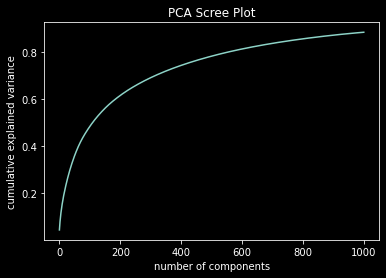

In [23]:
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')
# plt.title('PCA Scree Plot')
# evr = pca.explained_variance_ratio_
# cvr = np.cumsum(pca.explained_variance_ratio_)
# pca_df = pd.DataFrame()
# pca_df['Cumulative Variance Ratio'] = cvr
# pca_df['Explained Variance Ratio'] = evr

### 3.b - Transform train/test Document-Term-matrix with PCA

In [24]:
# dtm_train_pca = pca.transform(dtm_train)
# dtm_test_pca = pca.transform(dtm_test)

In [25]:
# # Build DataFrame of PCA Components
# col_names = ['PC_' + str(i) for i in range(1, pca.get_params()['n_components']+1)]
# dtm_train_pca_df = pd.DataFrame(dtm_train_pca, columns=col_names, index=dtm_train.index)
# dtm_test_pca_df = pd.DataFrame(dtm_test_pca, columns=col_names, index=dtm_test.index)

In [26]:
# # Combine PCA components and sentiment analysis scores into one DataFrame
# X_train_post_dtm_pca = pd.concat([X_train[['body_polarity','body_subjectivity']], dtm_train_pca_df], axis=1)
# X_test_post_dtm_pca = pd.concat([X_test[['body_polarity','body_subjectivity']],dtm_test_pca_df], axis=1)

## 4 Oversample minority class with SMOTE

In [29]:
# # sentiment analysis + PCA
# X_train_smote, y_train_smote = SMOTE().fit_resample(X_train_post_dtm_pca, y_train)
# X_test_smote, y_test_smote = SMOTE().fit_resample(X_test_post_dtm_pca, y_test)
# Counter(y_train_smote), Counter(y_test_smote)

(Counter({1: 16571, 0: 16571}), Counter({1: 168, 0: 168}))

In [40]:
# DTM 
X_train_dtm_smote, y_train_smote = SMOTE().fit_resample(dtm_train, y_train)
X_test_dtm_smote, y_test_smote = SMOTE().fit_resample(dtm_test, y_test)

In [41]:
# sentiment analysis + DTM
X_train_dtm_sen = pd.concat([X_train[['body_polarity','body_subjectivity']], dtm_train], axis=1)
X_test_dtm_sen = pd.concat([X_test[['body_polarity','body_subjectivity']], dtm_test], axis=1)
X_train_dtm_sen_smote, y_train_smote = SMOTE().fit_resample(X_train_dtm_sen, y_train)
X_test_dtm_sen_smote, y_test_smote = SMOTE().fit_resample(X_test_dtm_sen, y_test)

# Models

In [42]:
n=.3

## 1 - Logistic Regression

#### 1.b LR with DTM

In [119]:
start = time.time()
lr_dtm = LogisticRegression(max_iter=800, penalty='l2', solver='lbfgs')
lr_dtm.fit(X_train_dtm_smote, y_train_smote)
end = time.time()
print(f'run time = {(end-start)/60} mins')

dtm_model = lr_dtm
y_pred_train = dtm_model.predict(X_train_dtm_smote)
print(f'smote train : F1 Score = {f1_score(y_train_smote,y_pred_train):{n}f}')
print(f'smote train : Accuracy Score = {accuracy_score(y_train_smote,y_pred_train):{n}f}')
y_pred_test = dtm_model.predict(X_test_dtm_smote)
print(f'smote test : F1 Score = {f1_score(y_test_smote,y_pred_test):{n}f}')
print(f'smote test : Accuracy Score = {accuracy_score(y_test_smote,y_pred_test):{n}f}')
y_pred_train = dtm_model.predict(dtm_train)
print(f'no smote train : F1 Score = {f1_score(y_train,y_pred_train):{n}f}')
print(f'no smote train : Accuracy Score = {accuracy_score(y_train,y_pred_train):{n}f}')
y_pred_test = dtm_model.predict(dtm_test)
print(f'no smote test : F1 Score = {f1_score(y_test,y_pred_test):{n}f}')
print(f'no smote test : Accuracy Score = {accuracy_score(y_test,y_pred_test):{n}f}')

train smote
F1 Score = 0.805
Accuracy Score = 0.803
test smote
F1 Score = 0.740
Accuracy Score = 0.738
train no smote
F1 Score = 0.498
Accuracy Score = 0.716
test no smote
F1 Score = 0.373
Accuracy Score = 0.638


In [34]:
# start = time.time()
# lr_dtm_5 = LogisticRegression(max_iter=1000, penalty='l2', solver='lbfgs')
# lr_dtm_5.fit(X_train_dtm_smote, y_train_smote)
# end = time.time()
# print(f'run time = {(end-start)/60} mins')

dtm_model = lr_dtm_5
y_pred_train = dtm_model.predict(X_train_dtm_smote)
print(f'smote train : F1 Score = {f1_score(y_train_smote,y_pred_train):{n}f}')
print(f'smote train : Accuracy Score = {accuracy_score(y_train_smote,y_pred_train):{n}f}')
y_pred_test = dtm_model.predict(X_test_dtm_smote)
print(f'smote test : F1 Score = {f1_score(y_test_smote,y_pred_test):{n}f}')
print(f'smote test : Accuracy Score = {accuracy_score(y_test_smote,y_pred_test):{n}f}')
y_pred_train = dtm_model.predict(dtm_train)
print(f'no smote train : F1 Score = {f1_score(y_train,y_pred_train):{n}f}')
print(f'no smote train : Accuracy Score = {accuracy_score(y_train,y_pred_train):{n}f}')
y_pred_test = dtm_model.predict(dtm_test)
print(f'no smote test : F1 Score = {f1_score(y_test,y_pred_test):{n}f}')
print(f'no smote test : Accuracy Score = {accuracy_score(y_test,y_pred_test):{n}f}')

smote train : F1 Score = 0.772
smote train : Accuracy Score = 0.770
smote test : F1 Score = 0.740
smote test : Accuracy Score = 0.735
no smote train : F1 Score = 0.403
no smote train : Accuracy Score = 0.667
no smote test : F1 Score = 0.333
no smote test : Accuracy Score = 0.616


#### 1.c LR with DTM and Sentiment Analysis

In [113]:
start = time.time()
lr_dtm_sen = LogisticRegression(max_iter=800, penalty='l2', solver='lbfgs')
lr_dtm_sen.fit(X_train_dtm_sen_smote, y_train_smote)
end = time.time()
print(f'run time = {(end-start)/60} mins')

dtm_sen_model = lr_dtm_sen                        
y_pred_train = dtm_sen_model.predict(X_train_dtm_sen_smote)
print(f'smote train : F1 Score = {f1_score(y_train_smote,y_pred_train):{n}f}')
print(f'smote train : Accuracy Score = {accuracy_score(y_train_smote,y_pred_train):{n}f}')
y_pred_test = dtm_sen_model.predict(X_test_dtm_sen_smote)
print(f'smote test : F1 Score = {f1_score(y_test_smote,y_pred_test):{n}f}')
print(f'smote test : Accuracy Score = {accuracy_score(y_test_smote,y_pred_test):{n}f}')
y_pred_train = dtm_sen_model.predict(X_train_dtm_sen)
print(f'no smote train : F1 Score = {f1_score(y_train,y_pred_train):{n}f}')
print(f'no smote train : Accuracy Score = {accuracy_score(y_train,y_pred_train):{n}f}')
y_pred_test = dtm_sen_model.predict(X_test_dtm_sen)
print(f'no smote test : F1 Score = {f1_score(y_test,y_pred_test):{n}f}')
print(f'no smote test : Accuracy Score = {accuracy_score(y_test,y_pred_test):{n}f}')

train smote
F1 Score = 0.805
Accuracy Score = 0.804
test smote
F1 Score = 0.754
Accuracy Score = 0.753
train no smote
F1 Score = 0.498
Accuracy Score = 0.718
test no smote
F1 Score = 0.394
Accuracy Score = 0.655


In [35]:
# start = time.time()
# lr_dtm_sen_5 = LogisticRegression(max_iter=800, penalty='l2', solver='lbfgs')
# lr_dtm_sen_5.fit(X_train_dtm_sen_smote, y_train_smote)
# end = time.time()
# print(f'run time = {(end-start)/60} mins')
dtm_sen_model = lr_dtm_sen_5                        
y_pred_train = dtm_sen_model.predict(X_train_dtm_sen_smote)
print(f'smote train : F1 Score = {f1_score(y_train_smote,y_pred_train):{n}f}')
print(f'smote train : Accuracy Score = {accuracy_score(y_train_smote,y_pred_train):{n}f}')
y_pred_test = dtm_sen_model.predict(X_test_dtm_sen_smote)
print(f'smote test : F1 Score = {f1_score(y_test_smote,y_pred_test):{n}f}')
print(f'smote test : Accuracy Score = {accuracy_score(y_test_smote,y_pred_test):{n}f}')
y_pred_train = dtm_sen_model.predict(X_train_dtm_sen)
print(f'no smote train : F1 Score = {f1_score(y_train,y_pred_train):{n}f}')
print(f'no smote train : Accuracy Score = {accuracy_score(y_train,y_pred_train):{n}f}')
y_pred_test = dtm_sen_model.predict(X_test_dtm_sen)
print(f'no smote test : F1 Score = {f1_score(y_test,y_pred_test):{n}f}')
print(f'no smote test : Accuracy Score = {accuracy_score(y_test,y_pred_test):{n}f}')

smote train : F1 Score = 0.772
smote train : Accuracy Score = 0.771
smote test : F1 Score = 0.739
smote test : Accuracy Score = 0.736
no smote train : F1 Score = 0.401
no smote train : Accuracy Score = 0.668
no smote test : F1 Score = 0.326
no smote test : Accuracy Score = 0.620


## 2 - Random Forest Model

In [18]:
start = time.time()
rfc = RandomForestClassifier(n_jobs=-1, n_estimators=300, min_samples_split=3, criterion='entropy')
rfc.fit(X_train_dtm_smote, y_train_smote)
end = time.time()
print((end-start)/60)                      
dtm_model = rfc
y_pred_train = dtm_model.predict(X_train_dtm_smote)
print(f'smote train : F1 Score = {f1_score(y_train_smote,y_pred_train):{n}f}')
print(f'smote train : Accuracy Score = {accuracy_score(y_train_smote,y_pred_train):{n}f}')
y_pred_test = dtm_model.predict(X_test_dtm_smote)
print(f'smote test : F1 Score = {f1_score(y_test_smote,y_pred_test):{n}f}')
print(f'smote test : Accuracy Score = {accuracy_score(y_test_smote,y_pred_test):{n}f}')
y_pred_train = dtm_model.predict(dtm_train)
print(f'no smote train : F1 Score = {f1_score(y_train,y_pred_train):{n}f}')
print(f'no smote train : Accuracy Score = {accuracy_score(y_train,y_pred_train):{n}f}')
y_pred_test = dtm_model.predict(dtm_test)
print(f'no smote test : F1 Score = {f1_score(y_test,y_pred_test):{n}f}')
print(f'no smote test : Accuracy Score = {accuracy_score(y_test,y_pred_test):{n}f}')

2.0941745241483054
smote train : F1 Score = 1.000
smote train : Accuracy Score = 1.000
smote test : F1 Score = 0.721
smote test : Accuracy Score = 0.748
no smote train : F1 Score = 1.000
no smote train : Accuracy Score = 1.000
no smote test : F1 Score = 0.218
no smote test : Accuracy Score = 0.661


In [17]:
start = time.time()
rfc = RandomForestClassifier(n_jobs=-1, min_samples_split=3)
rfc.fit(X_train_dtm_smote, y_train_smote)
end = time.time()
print((end-start)/60)                      
dtm_model = rfc
y_pred_train = dtm_model.predict(X_train_dtm_smote)
print(f'smote train : F1 Score = {f1_score(y_train_smote,y_pred_train):{n}f}')
print(f'smote train : Accuracy Score = {accuracy_score(y_train_smote,y_pred_train):{n}f}')
y_pred_test = dtm_model.predict(X_test_dtm_smote)
print(f'smote test : F1 Score = {f1_score(y_test_smote,y_pred_test):{n}f}')
print(f'smote test : Accuracy Score = {accuracy_score(y_test_smote,y_pred_test):{n}f}')
y_pred_train = dtm_model.predict(dtm_train)
print(f'no smote train : F1 Score = {f1_score(y_train,y_pred_train):{n}f}')
print(f'no smote train : Accuracy Score = {accuracy_score(y_train,y_pred_train):{n}f}')
y_pred_test = dtm_model.predict(dtm_test)
print(f'no smote test : F1 Score = {f1_score(y_test,y_pred_test):{n}f}')
print(f'no smote test : Accuracy Score = {accuracy_score(y_test,y_pred_test):{n}f}')

0.7723018089930217
smote train : F1 Score = 1.000
smote train : Accuracy Score = 1.000
smote test : F1 Score = 0.722
smote test : Accuracy Score = 0.755
no smote train : F1 Score = 1.000
no smote train : Accuracy Score = 1.000
no smote test : F1 Score = 0.224
no smote test : Accuracy Score = 0.682


In [85]:
importances = pd.DataFrame(zip(cv.get_feature_names(), rfc.feature_importances_), columns=['word', 'importance'])

In [66]:
pipe.predict([aita['title_body_combo'][7]])

array([0])

In [71]:
input_text = """
I pushed my mom off a cliff after she said she will not buy me a playstation 5. She is now half dead and will never walk again, my whole family is mad at me, but I don't feel bad about it, aita?
"""

In [75]:
pipe = make_pipeline(cv, rfc)
explainer = LimeTextExplainer(class_names=['not asshole', 'asshole'])
exp = explainer.explain_instance(input_text, pipe.predict_proba, num_features=10)

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


In [76]:
exp.as_list()

[('bad', -0.02877932665855743),
 ('whole', -0.02628743321059801),
 ('feel', -0.024203004222855477),
 ('mom', -0.01456741452762069),
 ('family', -0.012341009901831795),
 ('walk', -0.010343294041865401),
 ('half', -0.009229858939423692),
 ('dead', -0.006329187998761002),
 ('mad', -0.004667982082166666),
 ('never', -0.004195945921755712)]

In [77]:
exp.show_in_notebook(text=False)

In [105]:
start = time.time()
rfc_sen = RandomForestClassifier(n_jobs=-1,min_samples_split=3)
rfc_sen.fit(X_train_dtm_sen_smote, y_train_smote)
end = time.time()
print((end-start)/60)
dtm_sen_model = rfc_sen                        
y_pred_train = dtm_sen_model.predict(X_train_dtm_sen_smote)
print(f'smote train : F1 Score = {f1_score(y_train_smote,y_pred_train):{n}f}')
print(f'smote train : Accuracy Score = {accuracy_score(y_train_smote,y_pred_train):{n}f}')
y_pred_test = dtm_sen_model.predict(X_test_dtm_sen_smote)
print(f'smote test : F1 Score = {f1_score(y_test_smote,y_pred_test):{n}f}')
print(f'smote test : Accuracy Score = {accuracy_score(y_test_smote,y_pred_test):{n}f}')
y_pred_train = dtm_sen_model.predict(X_train_dtm_sen)
print(f'no smote train : F1 Score = {f1_score(y_train,y_pred_train):{n}f}')
print(f'no smote train : Accuracy Score = {accuracy_score(y_train,y_pred_train):{n}f}')
y_pred_test = dtm_sen_model.predict(X_test_dtm_sen)
print(f'no smote test : F1 Score = {f1_score(y_test,y_pred_test):{n}f}')
print(f'no smote test : Accuracy Score = {accuracy_score(y_test,y_pred_test):{n}f}')

1.0026679237683613
smote train : F1 Score = 1.000
smote train : Accuracy Score = 1.000
smote test : F1 Score = 0.726
smote test : Accuracy Score = 0.762
no smote train : F1 Score = 1.000
no smote train : Accuracy Score = 1.000
no smote test : F1 Score = 0.219
no smote test : Accuracy Score = 0.691


In [106]:
# pickle.dump(rfc_sen, open('models/rfc_sen.sav', 'wb'))

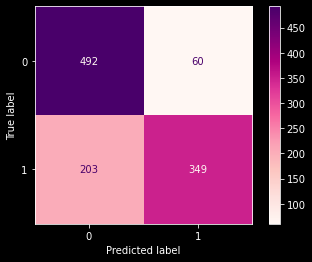

In [107]:
plot_confusion_matrix(rfc_sen, X_test_dtm_sen_smote, y_test_smote, cmap='RdPu');

## 3. Naive Bayes

In [96]:
start = time.time()
nb = MultinomialNB()
nb.fit(X_train_dtm_smote, y_train_smote)
end = time.time()
print((end-start)/60)
dtm_model = nb
y_pred_train = dtm_model.predict(X_train_dtm_smote)
print(f'smote train : F1 Score = {f1_score(y_train_smote,y_pred_train):{n}f}')
print(f'smote train : Accuracy Score = {accuracy_score(y_train_smote,y_pred_train):{n}f}')
y_pred_test = dtm_model.predict(X_test_dtm_smote)
print(f'smote test : F1 Score = {f1_score(y_test_smote,y_pred_test):{n}f}')
print(f'smote test : Accuracy Score = {accuracy_score(y_test_smote,y_pred_test):{n}f}')
y_pred_train = dtm_model.predict(dtm_train)
print(f'no smote train : F1 Score = {f1_score(y_train,y_pred_train):{n}f}')
print(f'no smote train : Accuracy Score = {accuracy_score(y_train,y_pred_train):{n}f}')
y_pred_test = dtm_model.predict(dtm_test)
print(f'no smote test : F1 Score = {f1_score(y_test,y_pred_test):{n}f}')
print(f'no smote test : Accuracy Score = {accuracy_score(y_test,y_pred_test):{n}f}')

train smote
F1 Score = 0.730
Accuracy Score = 0.726
test smote
F1 Score = 0.737
Accuracy Score = 0.735
train no smote
F1 Score = 0.446
Accuracy Score = 0.653
test no smote
F1 Score = 0.493
Accuracy Score = 0.681


## 4 - Support Vector Machines (SVM)

In [40]:
start = time.time()
SGD = SGDClassifier()
SGD.fit(X_train_dtm_smote, y_train_smote)
end = time.time()
print((end-start)/60)
print('train smote')
dtm_model = SGD
y_pred_train = dtm_model.predict(X_train_dtm_smote)
print(f'smote train : F1 Score = {f1_score(y_train_smote,y_pred_train):{n}f}')
print(f'smote train : Accuracy Score = {accuracy_score(y_train_smote,y_pred_train):{n}f}')
y_pred_test = dtm_model.predict(X_test_dtm_smote)
print(f'smote test : F1 Score = {f1_score(y_test_smote,y_pred_test):{n}f}')
print(f'smote test : Accuracy Score = {accuracy_score(y_test_smote,y_pred_test):{n}f}')
y_pred_train = dtm_model.predict(dtm_train)
print(f'no smote train : F1 Score = {f1_score(y_train,y_pred_train):{n}f}')
print(f'no smote train : Accuracy Score = {accuracy_score(y_train,y_pred_train):{n}f}')
y_pred_test = dtm_model.predict(dtm_test)
print(f'no smote test : F1 Score = {f1_score(y_test,y_pred_test):{n}f}')
print(f'no smote test : Accuracy Score = {accuracy_score(y_test,y_pred_test):{n}f}')

1.0649807651837666
train smote
smote train : F1 Score = 0.775
smote train : Accuracy Score = 0.790
smote test : F1 Score = 0.755
smote test : Accuracy Score = 0.772
no smote train : F1 Score = 0.337
no smote train : Accuracy Score = 0.698
no smote test : F1 Score = 0.289
no smote test : Accuracy Score = 0.676


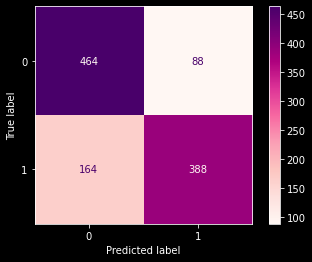

In [41]:
plot_confusion_matrix(SGD, X_test_dtm_smote, y_test_smote, cmap='RdPu');

In [90]:
start = time.time()
SGD_sen = SGDClassifier()
SGD_sen.fit(X_train_dtm_sen_smote, y_train_smote)
end = time.time()
print((end-start)/60)
dtm_sen_model = SGD_sen                        
y_pred_train = dtm_sen_model.predict(X_train_dtm_sen_smote)
print(f'smote train : F1 Score = {f1_score(y_train_smote,y_pred_train):{n}f}')
print(f'smote train : Accuracy Score = {accuracy_score(y_train_smote,y_pred_train):{n}f}')
y_pred_test = dtm_sen_model.predict(X_test_dtm_sen_smote)
print(f'smote test : F1 Score = {f1_score(y_test_smote,y_pred_test):{n}f}')
print(f'smote test : Accuracy Score = {accuracy_score(y_test_smote,y_pred_test):{n}f}')
y_pred_train = dtm_sen_model.predict(X_train_dtm_sen)
print(f'no smote train : F1 Score = {f1_score(y_train,y_pred_train):{n}f}')
print(f'no smote train : Accuracy Score = {accuracy_score(y_train,y_pred_train):{n}f}')
y_pred_test = dtm_sen_model.predict(X_test_dtm_sen)
print(f'no smote test : F1 Score = {f1_score(y_test,y_pred_test):{n}f}')
print(f'no smote test : Accuracy Score = {accuracy_score(y_test,y_pred_test):{n}f}')

1.0971169273058574
smote train : F1 Score = 0.778
smote train : Accuracy Score = 0.782
smote test : F1 Score = 0.747
smote test : Accuracy Score = 0.752
no smote train : F1 Score = 0.400
no smote train : Accuracy Score = 0.686
no smote test : F1 Score = 0.325
no smote test : Accuracy Score = 0.645


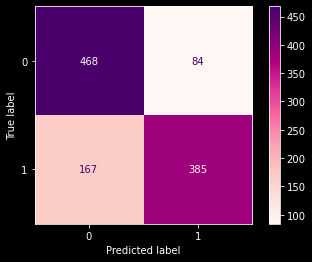

In [44]:
plot_confusion_matrix(SGD_sen, X_test_dtm_sen_smote, y_test_smote,cmap='RdPu');

# Testing

In [132]:
aita_clean = pd.read_csv('data/aita_clean.csv')

In [253]:
tops = aita_clean[['title','body','verdict','is_asshole','score']].sort_values('score', ascending=False).head(500)

In [47]:
diag_tops = Proctologist(model=SGD_sen, sentiment=True, cv=cv).diagnosis(tops['body'].values)
diag_tops['true_verdict'] = tops['is_asshole'].values
diag_tops['correct_prediction'] = diag_tops['true_verdict'] == diag_tops['asshole']
sum(diag_tops.correct_prediction)/len(diag_tops.correct_prediction)

NameError: name 'tops' is not defined

In [177]:
diag_tops = Proctologist(model=SGD, sentiment=False).diagnosis(tops['body'].values)
diag_tops['true_verdict'] = tops['is_asshole'].values
diag_tops['correct_prediction'] = diag_tops['true_verdict'] == diag_tops['asshole']
sum(diag_tops.correct_prediction)/len(diag_tops.correct_prediction)

0.72

In [178]:
# diag_tops = Proctologist(model=nb, sentiment=False).diagnosis(tops['body'].values)
# diag_tops['true_verdict'] = tops['is_asshole'].values
# diag_tops['correct_prediction'] = diag_tops['true_verdict'] == diag_tops['asshole']
# sum(diag_tops.correct_prediction)/len(diag_tops.correct_prediction)

0.608

In [179]:
diag_tops = Proctologist(model=rfc_sen, sentiment=True).diagnosis(tops['body'].values)
diag_tops['true_verdict'] = tops['is_asshole'].values
diag_tops['correct_prediction'] = diag_tops['true_verdict'] == diag_tops['asshole']
sum(diag_tops.correct_prediction)/len(diag_tops.correct_prediction)

0.852

In [180]:
diag_tops = Proctologist(model=lr_dtm, sentiment=False).diagnosis(tops['body'].values)
diag_tops['true_verdict'] = tops['is_asshole'].values
diag_tops['correct_prediction'] = diag_tops['true_verdict'] == diag_tops['asshole']
sum(diag_tops.correct_prediction)/len(diag_tops.correct_prediction)

0.69

In [181]:
diag_tops = Proctologist(model=lr_dtm_sen, sentiment=True).diagnosis(tops['body'].values)
diag_tops['true_verdict'] = tops['is_asshole'].values
diag_tops['correct_prediction'] = diag_tops['true_verdict'] == diag_tops['asshole']
sum(diag_tops.correct_prediction)/len(diag_tops.correct_prediction)

0.686

## Testing with fake conflict

Random Forest with sentiment

In [289]:
# texts = ['I pushed my mom off a cliff after she said she will buy me a playstation 5, and my whole family is mad at me, but I don\'t feel bad about it, aita?',
#         'I found out my boyfriend cheated on me with my bestfriend, I can hardly believe they would betray me like this under my eye. I cut contact with them both after they showed no remorse. But our mutual friends are saying I should be happy for them',
#         'I cheated on my boyfriend and he kicked me out of his house, I broke in in the middle of night, I did not pay rent.',
#          'I talked to my ex on a regular basis, my girlfriend doesn\'t know about it, and she isn\'t happy about it, she said she\'s going to leave me',
#         "I am 27(f) and my husband is 26 So for those who don't know playboi carti is a 'rapper' who dresses pretty feminine and talks pretty strange (His music is interesting, to say the least). So recently my husband began listening to Carti and other artists at first I didn't care because I'm not controlling I let him listen to what he wants. but starting last week my husband began spending large sums on money on designer clothes like the ones playboi carti wears I was a bit annoyed but it was his money. But what really pissed me off is that he started talking like carti saying things like \"slatt\" \"slime\" and other slang words that are pretty strange for a suburban white man to say. I've told him multiple times that I don't like this new him but he continues to do these things he only listens to Playboi carti and I think his music is starting to brainwash him? WIBTA if I imposed a ban on listening to Carti's music for a while so my husband can get a better handle on himself and stop buying thousands of dollars worth of Rick Owens. I'm worrying that maybe it would be controlling and maybe a bit crazy if I did.",
#         'AITA for telling my stepdaughter to stop using period products in the bathroom she shares with my teenage sons?']
# true_verdict = [1,0,1,1,1,1]

In [76]:
texts=["""
I have 2 children, a 9 year old son and a 6 year old daughter. My son had a Minecraft world where he built quite an impressive castle on an island, which he was very proud to show to me.
Since school was canceled, he has had issues with waking up on time. He is supposed to wake up at 7 each morning, but for the past month he has been sleeping in until about 9 or 10. I always set an alarm for him, but he sleeps right through it. I don't wake him up because waking himself up is a skill that he needs to learn. I told him about 2 weeks ago that there are going to be consequences for him if he continues to sleep in every morning. At first, he understood and was waking up on time every morning. But for the past week or so, he has fallen back into old habits. I told him yesterday that this is his final warning. Today, he slept in until 11.
So I followed through with my warning, and went on the computer and deleted his favorite Minecraft world. I also took away computer privileges for the next month. When I told him, he started screaming and crying. He told me that he spent a whole year working on that world, and he's very distraught that he's never going to see it again. He has been crying and sobbing throughout the day, and has refused to eat any of his meals.
"""]
true_verdict = [0]

SGD without sentiment

In [77]:
diag = Proctologist(model=SGD_sen, sentiment=True, cv=cv).diagnosis(texts)
diag['true_verdict'] = true_verdict
diag['correct_prediction'] = diag['true_verdict'] == diag['asshole']
# sum(diag.correct_prediction)/len(diag.correct_prediction)
diag

,text,asshole,true_verdict,correct_prediction
0,"\nI have 2 children, a 9 year old son and a 6 ...",0,0,True


In [78]:
diag_rfc = Proctologist(model=rfc_sen, sentiment=True, cv=cv).diagnosis(texts)
diag_rfc['true_verdict'] = true_verdict
diag_rfc['correct_prediction'] = diag_rfc['true_verdict'] == diag_rfc['asshole']
diag_rfc

,text,asshole,true_verdict,correct_prediction
0,"\nI have 2 children, a 9 year old son and a 6 ...",0,0,True


In [69]:
diag_SGD = Proctologist(model=SGD, sentiment=False, cv=cv).diagnosis(texts)
diag_SGD['true_verdict'] = true_verdict
diag_SGD['correct_prediction'] = diag_SGD['true_verdict'] == diag_SGD['asshole']
diag_rfc

,text,asshole,true_verdict,correct_prediction
0,"\nI think I'm in the right on this, but I've a...",0,0,True
